In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from transformers import GPT2Model, GPT2Config
import skimage as sk
import random

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(device)

to_numpy = lambda x: x.detach().cpu().numpy()

cuda:1


Files already downloaded and verified


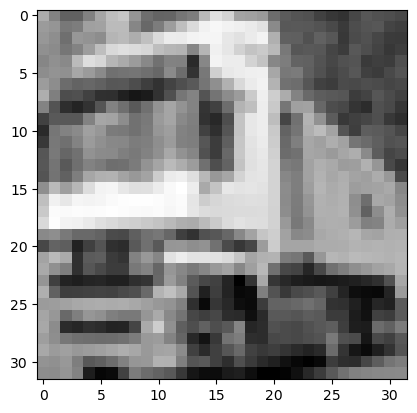

In [2]:
cifar = torchvision.datasets.CIFAR10(download=True, root='.')
cifar = cifar.data.transpose((0, 3, 1 ,2)).mean(1, keepdims=True)
# cifar = (cifar - cifar.mean((0, 2, 3), keepdims=True)) / (cifar.std((0, 2, 3), keepdims=True))
plt.imshow(cifar[1, 0], cmap='gray')

In [3]:
cifar_small = sk.transform.rescale(cifar, 0.5)
cifar_mini = sk.transform.rescale(cifar, 0.25)

(89400, 1, 16, 16)
(89400, 5)
[1. 0. 0. 0. 0.]


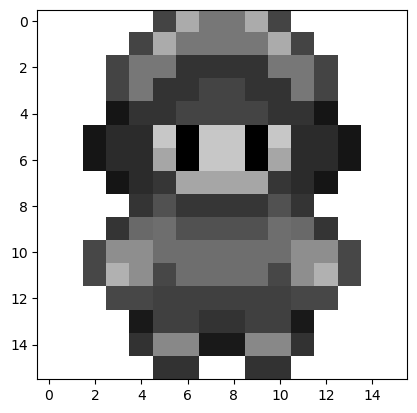

In [4]:
sprites = np.load('sprites.npy')
sprites = np.transpose(sprites, (0, 3, 1, 2)).mean(axis=1, keepdims=True)
sprite_labels = np.load('sprites_labels.npy')
print(sprites.shape)
print(sprite_labels.shape)
plt.imshow(sprites[0, 0], cmap='gray')
print(sprite_labels[0])

In [5]:
class PatchEmbed(nn.Module):
    def __init__(self, image_size=16, patch_size=2, in_chans=1, embed_dim=256):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.grid_h = image_size // patch_size
        self.grid_w = image_size // patch_size
        self.h_embed = nn.Parameter(torch.randn(1, embed_dim, self.grid_h, 1))
        self.w_embed = nn.Parameter(torch.randn(1, embed_dim, 1, self.grid_w))

    def forward(self, x):
        x = self.proj(x)  # [B, D, H/patch, W/patch]
        x = x + self.h_embed + self.w_embed
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, D]
        return x

In [6]:
class SimpleViT(nn.Module):
    def __init__(self, image_size=16, patch_size=2, embed_dim=256, num_layers=4, nhead=4):
        super().__init__()
        self.patch_embed = PatchEmbed(image_size=image_size, embed_dim=embed_dim, patch_size=patch_size)
        encoder = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder, num_layers=num_layers)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        patches = self.patch_embed(x)  # [B*T, P, D]
        # patches = patches.view(B, T, -1, patches.shape[-1])  # [B, T, P, D]
        # patches = patches.flatten(1, 2)  # [B, T*P, D]
        embeddings = self.transformer(patches)[:, -1, :]
        embeddings = embeddings.view(B, T, -1)
        return embeddings

class MiniResnet(nn.Module):
    def __init__(self, image_size=16, embed_dim=256, num_layers=8):
        super().__init__()
        self.input_conv = nn.Conv2d(1, 32, 3, 1, 1)
        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(nn.Conv2d(32, 32, 3, 1, 1))
        self.output = nn.Linear(image_size**2 *32, embed_dim)
    
    def forward(self, x):
        x = F.relu(self.input_conv(x))
        for layer in self.convs:
            x = F.relu(layer(x)) + x
        x = x.flatten(1)
        x = self.output(x)
        return x


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, image_size=16, embed_dim=1, num_convs=1, num_channels=1, patch_size=2):
        # Let's just do x convs followed by a single linear layer
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(nn.Conv2d(1, num_channels, kernel_size=patch_size, stride=patch_size, bias=False))
        for i in range(num_convs - 1):
            self.convs.append(nn.Conv2d(num_channels, num_channels, kernel_size=patch_size, padding='same', bias=False))
        self.conv_size = num_channels * (image_size * image_size) // (patch_size * patch_size)
        self.linear = nn.Linear(self.conv_size, embed_dim, bias=False)
        self._initialize_weights()

    def forward(self, x):
        for conv in self.convs:
            x = F.relu(conv(x))
        x = x.flatten(1)
        x = self.linear(x)
        return x
    
    def _initialize_weights(self):
        layers = [m for m in self.modules() if isinstance(m, (nn.Linear, nn.Conv2d))]
        for i, m in enumerate(layers):
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.normal_(m.weight)

class SimpleMLP(nn.Module):
    def __init__(self, image_size=16, embed_dim=1, hidden_dim=100, num_hidden=0):
        super().__init__()
        self.input_size = image_size ** 2
        self.hidden_dim = hidden_dim
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(self.input_size, hidden_dim, bias=False))
        for _ in range(num_hidden):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim, bias=False))
        self.output_layer = nn.Linear(hidden_dim, embed_dim, bias=False)
        self._initialize_weights()
        
    def forward(self, x):
        x = x.flatten(1)
        for layer in self.layers:
            x = F.relu(layer(x))
        return self.output_layer(x)
        
    def _initialize_weights(self):
        layers = [m for m in self.modules() if isinstance(m, (nn.Linear, nn.Conv2d))]
        for i, m in enumerate(layers):
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                if i < len(layers) - 1:
                    nn.init.normal_(m.weight)
                else:
                    nn.init.normal_(m.weight, std=2/self.hidden_dim)
            

In [8]:
class VisionICLTransformer(nn.Module):
    def __init__(self, val_dim=1, embed_dim=256, num_heads=8, num_layers=12, vit_heads=2, vit_layers=8,
                 image_size=16, patch_size=2, max_seq_len=128):
        # max_seq_len corresponds to 2k, so k x_k samples and k f(x_k), and then one more for x_query
        super().__init__()

        self.grid_h = image_size // patch_size
        self.grid_w = image_size // patch_size
        self.num_patches = self.grid_h * self.grid_w

        self.time_embed = nn.Parameter(torch.randn(1, max_seq_len * 2, embed_dim))

        self.val_dim = val_dim
        self.value_proj = nn.Linear(val_dim, embed_dim)

        self.vit = SimpleViT(image_size, patch_size, embed_dim, vit_layers, vit_heads)
        self.cnn = MiniResnet(image_size, embed_dim=embed_dim)
        # decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        # self.transformer = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        config = GPT2Config(
            n_positions=2 * max_seq_len,
            n_embd=embed_dim,
            n_layer=num_layers,
            n_head=num_heads,
            resid_pdrop=0.0,
            embd_pdrop=0.0,
            attn_pdrop=0.0,
            use_cache=False,
        )
        self.transformer = GPT2Model(config)

        self.fc_out = nn.Linear(embed_dim, val_dim)

    def forward(self, images, values):
        B, T, C, H, W = images.shape
        B, T, _ = values.shape
        # images = images.reshape(-1, *images.shape[2:])
        img_embeddings = self.vit(images) #self.cnn(images)
        # img_embeddings = img_embeddings.reshape(B, T, -1)
        # img_embeddings = self.vit(images)

        inds = torch.arange(T).to(device)

        val_embeds = self.value_proj(values)

        embeddings = self.interleave(img_embeddings, val_embeds)
        # embeddings = embeddings + self.time_embed[:, :2 * T]

        # mask = nn.Transformer.generate_square_subsequent_mask(2 * T).to(embeddings.device)
        # memory = torch.zeros(B, 1, embeddings.shape[-1]).to(embeddings.device)
        # x = self.transformer(tgt=embeddings, memory=memory, tgt_mask=mask) 

        # return self.fc_out(x[:, ::2])
        x = self.transformer(inputs_embeds=embeddings).last_hidden_state
        predictions = self.fc_out(x)

        return predictions[:, ::2, 0][:, inds]
    
    def interleave(self, xs, ys):
        B, T, D = xs.shape
        stacked = torch.stack((xs, ys), dim=2)  # [B, T, 2, D]
        interleaved = stacked.view(B, 2 * T, D)
        return interleaved

Actual Toy Problem

In [9]:
def sample_image_set(image_set, b, n, d=None):
    indices = torch.randint(0, image_set.shape[0], (b * n,))
    images = image_set[indices].reshape(b, n, *image_set.shape[1:])
    shape = images.shape
    images = (images - image_set.mean()) / (image_set.std() + 1e-8)
    images = torch.tensor(images).float().to(device)
    # images = images.reshape(b, n, 1, -1)
    if d is not None:
        images[:, :, :, d:] = 0
        images[:, :, :, :, d:] = 0
    # images = images.reshape(shape)
    return images

# def sample_sprites(b, n):
#     indices = torch.randint(0, sprites.shape[0], (b, n))
#     images = torch.tensor(sprites[indices]).float().to(device)
#     return images

# def sample_cifar(b, n, d):
#     indices = torch.randint(0, cifar.shape[0], (b, n))
#     images = torch.tensor(cifar[indices]).float().to(device)
#     images[:, :, :, d:] = 0
#     images[:, :, :, :, d:] = 0
#     return images

def sample_noise(b, n, d, d_max=16):
    noise = torch.randn((b, n, 1, d_max, d_max))
    noise[:, :, :, d:] = 0
    noise[:, :, :, :, d:] = 0
    return noise.to(device)

def ensemble_predict(models, images):
    predictions = []
    for i in range(len(models)):
        predictions.append(models[i](images[i]))
        
    return torch.concat(predictions)

def anneal_lr(optim, lr, update, num_updates, transition_step=1000):
    update -= 1
    if update <= transition_step:
        new_lr = lr * (0.5 ** (update / transition_step))
    else:
        frac = 1 - (update - transition_step) / (num_updates - transition_step)
        new_lr = max(0, 0.5 * lr * frac) # max probably unneccesary but better than having a negative
    optim.param_groups[0]["lr"] = new_lr

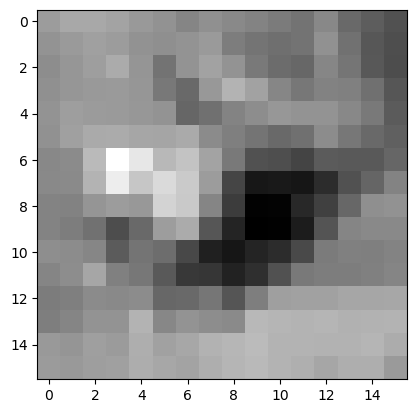

In [10]:
plt.imshow(to_numpy(sample_image_set(cifar_small, 1, 4, 32))[0, 0, 0], cmap='gray')

In [11]:
total_updates = 300000
increase_after = 5000
b = 64
d = 2
k = 5
n = d * k + 1 # might need to lower this back to 64 for colab
e = b
lr = 1e-5
image_size = 8
stop_on = 0.01
current_i = 0
weighting = ((torch.arange(1, n+1) * 2 / n) ** 2).to(device)
print(weighting)

losses = []
final_losses = []
large_transformer = VisionICLTransformer(image_size=image_size, patch_size=4, vit_layers=12).to(device)
optim = torch.optim.AdamW(large_transformer.parameters(), lr)
for i in range(1, total_updates + 1):
    # anneal_lr(optim, lr, i, total_updates, transition_step=20000)
    if i % 100 == 0:
        print(f'epoch: {i}, {np.mean(losses[-10:])}, {np.mean(final_losses[-10:])}, {f_xquery.norm(dim=-1).mean().item()}, {true_f_xquery.norm(dim=-1).mean().item()}')
    if i - current_i == increase_after:
        if d < image_size:
            d += 1
            n = d * k + 1
            increase_after += 0
            current_i = i
            weighting = ((torch.arange(n) * 2 / n) ** 2).to(device)
            print(f'increasing difficulty to d={d}, n={n}')
        elif np.mean(final_losses[-10:]) < stop_on:
            break
    models = [SimpleCNN(image_size).to(device) for _ in range(b)]
    images = sample_image_set(cifar_mini, b, n, d)
    # images = sample_noise(b, n, d, image_size)
    embeddings = ensemble_predict(models, images)
    true_f_xquery= embeddings = embeddings.reshape(b, n, -1)
    f_xquery = large_transformer(images, embeddings)
    true_f_xquery = true_f_xquery.squeeze(-1)
    loss = (weighting * (f_xquery - true_f_xquery) ** 2).sum(1).mean() # * weighting.view(1, -1)
    final_loss = F.mse_loss(f_xquery[:, -1], true_f_xquery[:, -1])
    final_losses.append(final_loss.item())
    losses.append(loss.item())
    optim.zero_grad()
    loss.backward()
    optim.step()

tensor([0.0331, 0.1322, 0.2975, 0.5289, 0.8264, 1.1901, 1.6198, 2.1157, 2.6777,
        3.3058, 4.0000], device='cuda:1')
epoch: 100, 39.40476703643799, 2.5312382698059084, 2.167236089706421, 3.1420974731445312
epoch: 200, 40.34879093170166, 2.825751003623009, 2.0911715030670166, 3.8295319080352783
epoch: 300, 40.3372142791748, 1.9635031700134278, 2.6392621994018555, 3.5663251876831055
epoch: 400, 27.18043384552002, 1.8523598492145539, 1.5120189189910889, 2.6573357582092285
epoch: 500, 19.437535190582274, 0.8235744506120681, 2.0480055809020996, 2.872068405151367
epoch: 600, 29.00683813095093, 2.389714163541794, 1.5841865539550781, 2.9720542430877686
epoch: 700, 24.073626136779787, 1.296381449699402, 2.5000391006469727, 3.498293399810791
epoch: 800, 27.983927536010743, 1.815904575586319, 2.1111745834350586, 3.2101423740386963
epoch: 900, 26.581917572021485, 1.4900855898857117, 1.5132806301116943, 3.2443015575408936
epoch: 1000, 32.91649675369263, 1.8942463159561158, 2.1310231685638428, 

KeyboardInterrupt: 

In [ ]:
# torch.save(large_transformer.state_dict(), 'exp3_model.pt')

In [ ]:
images = sample_image_set(cifar_mini, b, n, d)
testcnn = SimpleCNN(image_size).to(device)
embeddings = testcnn(images.reshape(b * n, 1, image_size, image_size))
true_f_xquery = embeddings = embeddings.reshape(b, n, -1)
f_xquery = large_transformer(images, embeddings)
true_f_xquery = true_f_xquery.squeeze(-1)
F.mse_loss(f_xquery[:, -1], true_f_xquery[:, -1])
print(f_xquery[:, -1])
print(true_f_xquery[:, -1])

tensor([-3.3670, -0.8374, -0.8020, -0.7125, -1.1386, -0.4960, -1.2444, -0.3060,
        -0.7515, -1.7429, -1.7482, -0.8571, -1.4543, -1.9456, -2.1560, -0.7443,
        -3.6499, -1.4974, -0.4456, -0.9363, -0.6172, -0.6431, -2.5569, -2.7063,
        -0.7595, -1.6962, -0.4311, -0.5113, -1.6055, -2.1963, -1.6276, -3.0955,
        -1.9674, -0.6198, -1.9956, -1.6917, -0.5312, -0.5139, -1.5179, -1.5603,
        -0.8287, -2.3736, -0.3921, -0.6882, -1.7527, -0.9424, -0.9154, -1.5507,
        -0.7746, -0.2443, -1.1702, -0.2301, -2.4996, -0.4357, -0.8577, -0.1203,
        -0.8054, -3.6366, -2.0074, -1.1432, -1.0902, -1.6596, -0.8031, -0.5571],
       device='cuda:1', grad_fn=<SelectBackward0>)
tensor([ 6.1204e-02, -1.5064e+00, -1.9267e+00, -6.5524e-01,  0.0000e+00,
         5.2506e-01,  5.6935e-01, -4.8448e+00, -2.1673e+00, -4.0671e+00,
        -2.7940e+00,  0.0000e+00, -3.0368e+00,  0.0000e+00,  0.0000e+00,
        -3.6930e-01, -5.5602e+00, -2.8050e+00, -2.4113e+00,  9.9732e-02,
        -4.7724e

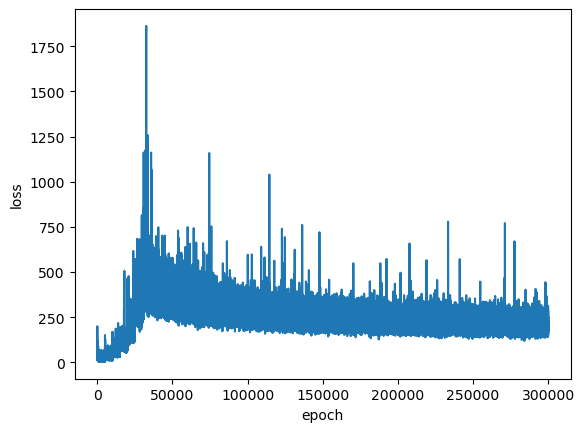

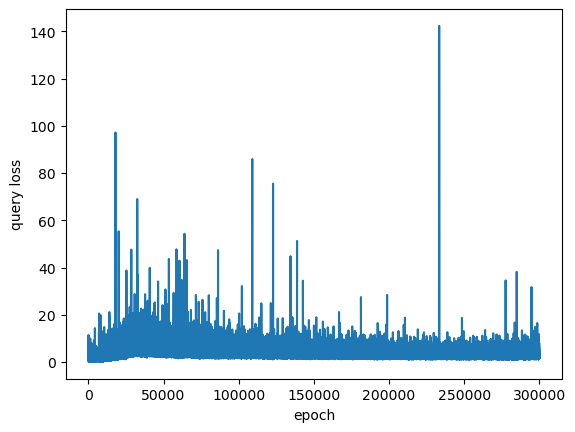

In [ ]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('exp3_loss.png')
plt.show()
plt.plot(final_losses)
plt.xlabel('epoch')
plt.ylabel('query loss')
plt.savefig('exp3_query_loss.png')